# Digit Recognizer (MNIST) – End-to-End Computer Vision Project

<img src="https://media.licdn.com/dms/image/v2/C4D12AQHehEuPPMxcdQ/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1572017514759?e=2147483647&v=beta&t=4X-Qy_EN4h3c_N7yiQ3M1zue6kpjyMBfyrWlrkNVGgY">

## 🎯 Project Objective

The objective of this project is to build an **end-to-end computer vision pipeline** for handwritten digit recognition using the MNIST dataset (Digit Recognizer competition).

This project focuses on:
- Understanding the full ML workflow (EDA → preprocessing → modeling → evaluation)
- Training a **custom CNN** (not just copying a solution)
- Using **data augmentation** with a clear cause–effect analysis
- Performing **error analysis** (e.g., confusion matrix) to understand model weaknesses

Ultimately, the trained model can be packaged for deployment (e.g., a simple demo app) to demonstrate a real-world use case. 🚀

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


## 📊 Exploratory Data Analysis (EDA)

### Dataset structure 🧩
- `train.csv`: **42,000 rows × 785 columns**
  - 1 target column: `label`
  - 784 pixel features representing a **28×28** grayscale image
- `test.csv`: **28,000 rows × 784 columns** (no label)
- Pixel values are in the range **0–255**

### Label distribution 🔢
The label distribution is approximately balanced across digits 0–9.
This indicates that **class imbalance is not a major issue**, so class weights are not required for baseline modeling ✅.

### Pixel intensity characteristics 🎨
Most pixel values are **0 (background)**, meaning the images are sparse and information is concentrated in the digit strokes.
This strongly motivates using **CNNs**, which are well-suited for learning spatial patterns such as edges and shapes.

### Ink amount (sum of pixels) 🖊️
Different digits naturally contain different stroke density ("ink amount"):
- Digits like **1** tend to have lower pixel sums (thinner strokes)
- Digits like **0, 8, 9** often have higher pixel sums (rounded shapes and more filled regions)

This suggests that digits may vary in complexity and writing style, making **regularization and data augmentation** useful to improve generalization ✅.

### Modeling implications ✅
Based on EDA, the planned approach is:
- Normalize pixel values to **[0, 1]**
- Reshape inputs to **(28, 28, 1)**
- Train a **custom CNN**
- Add **data augmentation** (rotation/shift/zoom) to reduce overfitting
- Evaluate using accuracy and error analysis (confusion matrix)

In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df  = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
sample_df = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [10]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.shape

(42000, 785)

In [12]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.shape

(28000, 784)

In [13]:
sample_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
sample_df.shape

(28000, 2)

In [14]:
N = 4000  
train_s = train_df.sample(N, random_state=42).reset_index(drop=True)

/tmp/ipykernel_55/1453892632.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=train_s, order=sorted(train_s["label"].unique()),palette="summer")


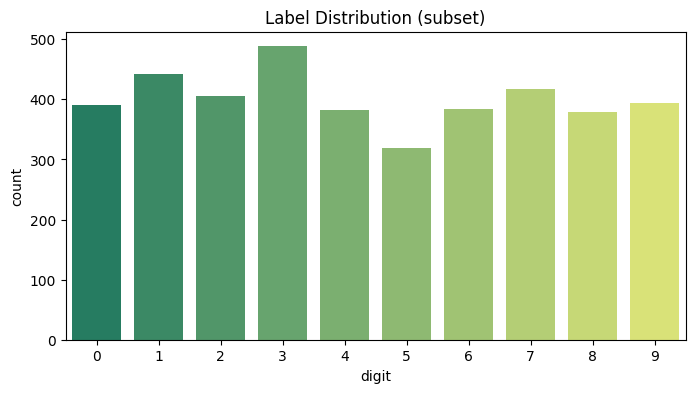

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x="label", data=train_s, order=sorted(train_s["label"].unique()),palette="summer")
plt.title("Label Distribution (subset)")
plt.xlabel("digit")
plt.ylabel("count")
plt.show()

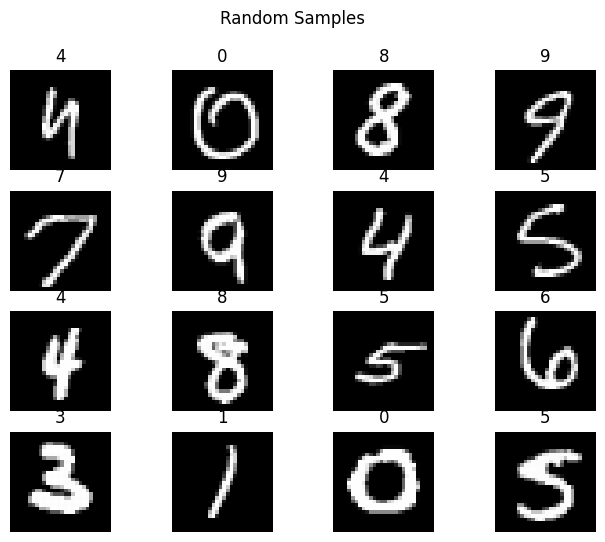

In [33]:
k = 16
rows = train_s.sample(k, random_state=42)

plt.figure(figsize=(8,6))
for i, (_, r) in enumerate(rows.iterrows()):
    img = r.drop("label").values.reshape(28,28)
    plt.subplot(4,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(int(r["label"]))
    plt.axis("off")
plt.suptitle("Random Samples")
plt.show()

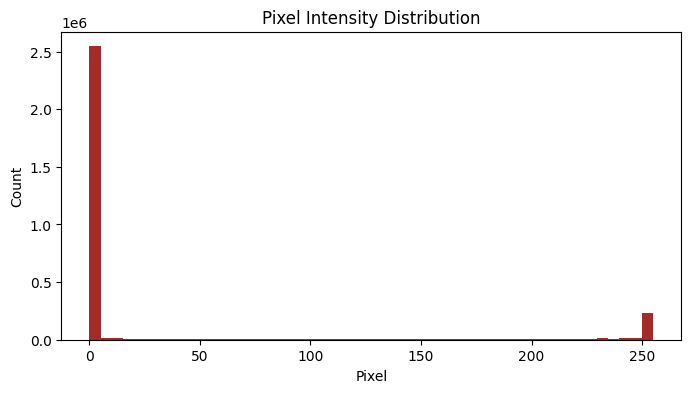

In [30]:
pix = train_s.drop(columns=["label"]).values.flatten()

plt.figure(figsize=(8,4))
plt.hist(pix, bins=50, color="brown")
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel")
plt.ylabel("Count")
plt.show()

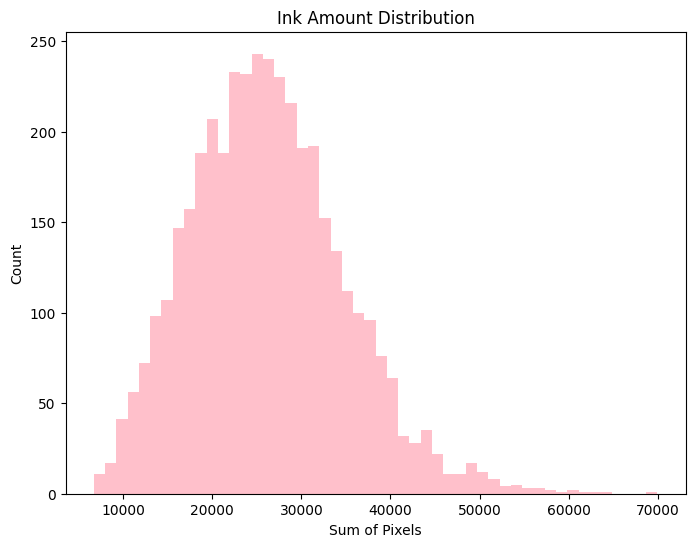

In [28]:
ink = train_s.drop(columns=["label"]).sum(axis=1)

plt.figure(figsize=(8,6))
plt.hist(ink, bins=50, color="pink")
plt.title("Ink Amount Distribution")
plt.xlabel("Sum of Pixels")
plt.ylabel("Count")
plt.show()

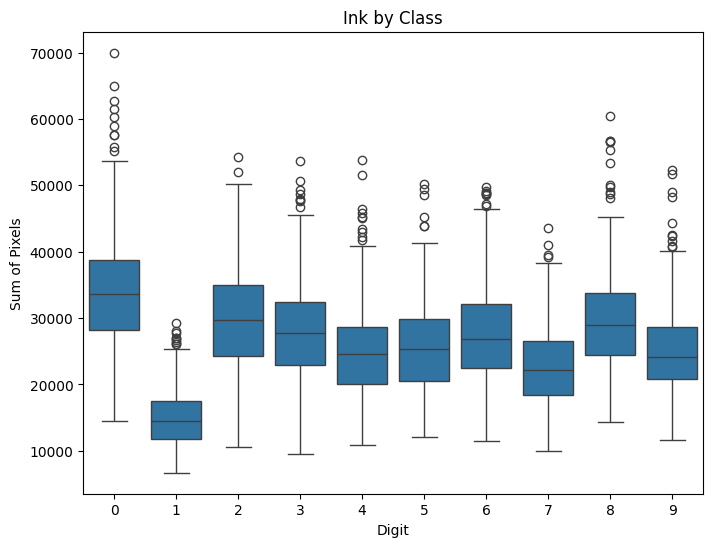

In [27]:
tmp = train_s.copy()
tmp["ink"] = tmp.drop(columns=["label"]).sum(axis=1)

plt.figure(figsize=(8,6))
sns.boxplot(data=tmp, x="label", y="ink")
plt.title("Ink by Class")
plt.xlabel("Digit")
plt.ylabel("Sum of Pixels")
plt.show()

In [34]:
y = train_df["label"].values
x = train_df.drop(columns=["label"]).values

In [35]:
x = x / 255.0 #normalize
x = x.reshape(-1, 28, 28, 1)
y_cat = to_categorical(y, num_classes=10) #one-hot

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x, y_cat,test_size=0.1,random_state=42,stratify=y)

In [37]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.10,
    height_shift_range=0.10)

In [39]:
datagen.fit(x_train)

In [42]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation="softmax")])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,754 (1.27 MB)

 Trainable params: 330,858 (1.26 MB)

 Non-trainable params: 896 (3.50 KB)

In [43]:
optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [44]:
lr_reduce = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6)

In [48]:
batch_size = 64
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    epochs=20,
    callbacks=[lr_reduce],
    verbose=1)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9850 - loss: 0.0449 - val_accuracy: 0.9957 - val_loss: 0.0159 - learning_rate: 5.0000e-04
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9869 - loss: 0.0412 - val_accuracy: 0.9926 - val_loss: 0.0219 - learning_rate: 5.0000e-04
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9885 - loss: 0.0384 - val_accuracy: 0.9960 - val_loss: 0.0165 - learning_rate: 5.0000e-04
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9885 - loss: 0.0370 - val_accuracy: 0.9967 - val_loss: 0.0143 - learning_rate: 5.0000e-04
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9892 - loss: 0.0358 - val_accuracy: 0.9967 - val_loss: 0.0144 - learning_rate: 5.0000e-04
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9952 - val_loss: 0.0198 - learning_rate: 5.0000e-04
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

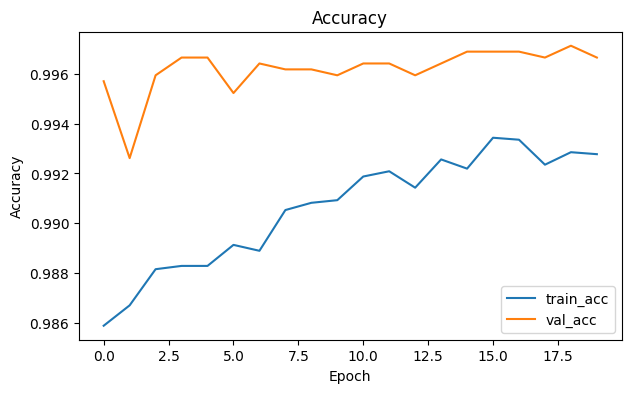

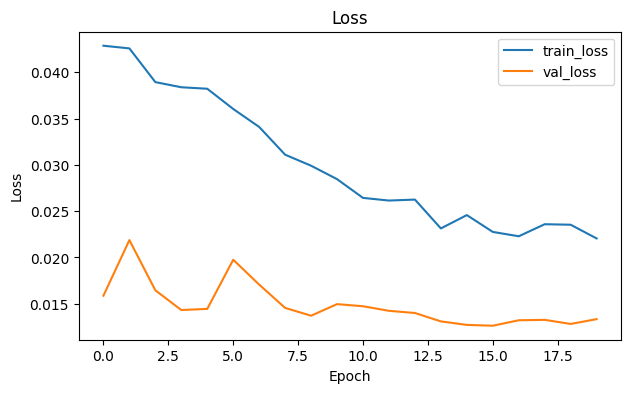

In [49]:
plt.figure(figsize=(7,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


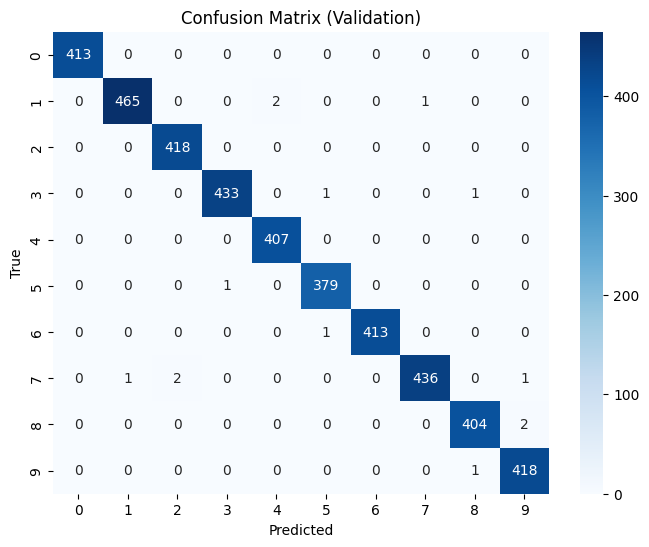

In [50]:
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(x_val), axis=1)

cm = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [51]:
x_test = test_df.values / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)

test_pred = np.argmax(model.predict(x_test), axis=1)
test_pred[:10]

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [52]:
submission = sample_df.copy()
submission["Label"] = test_pred

In [53]:
submission.to_csv("submission.csv", index=False)

In [54]:
model.save("mnist_cnn.keras")

In [55]:
model.save("mnist_cnn.h5")